In [1]:
import os
import numpy as np
import torch
import cv2
import torch.nn as nn
from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
#from pytorch_grad_cam import GradCAMPlusPlus
#from pytorch_grad_cam.utils.image import show_cam_on_image

# Dataset

## EDA

In [2]:
raw_dataset = datasets.ImageFolder(
    root="/kaggle/input/malignant-lymphoma-classification",
    transform=None
)

In [3]:
print("Classes:", raw_dataset.classes)  
print("Class to index mapping:", raw_dataset.class_to_idx)

Classes: ['CLL', 'FL', 'MCL']
Class to index mapping: {'CLL': 0, 'FL': 1, 'MCL': 2}


CLL: 113 images
FL: 139 images
MCL: 122 images


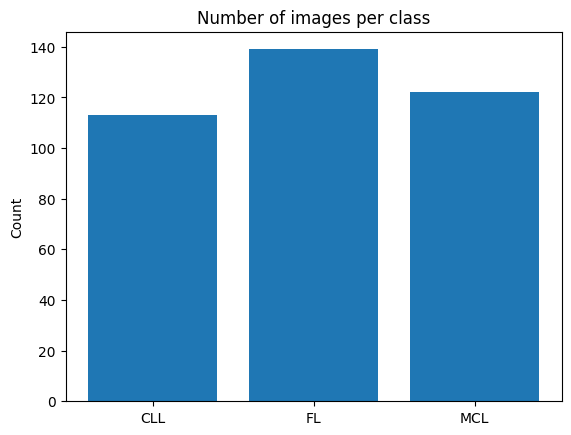

In [4]:
class_counts = Counter(raw_dataset.targets)
classes = raw_dataset.classes

for cls, count in zip(classes, [class_counts[i] for i in range(len(classes))]):
    print(f"{cls}: {count} images")

plt.bar(classes, [class_counts[i] for i in range(len(classes))])
plt.title("Number of images per class")
plt.ylabel("Count")
plt.show()

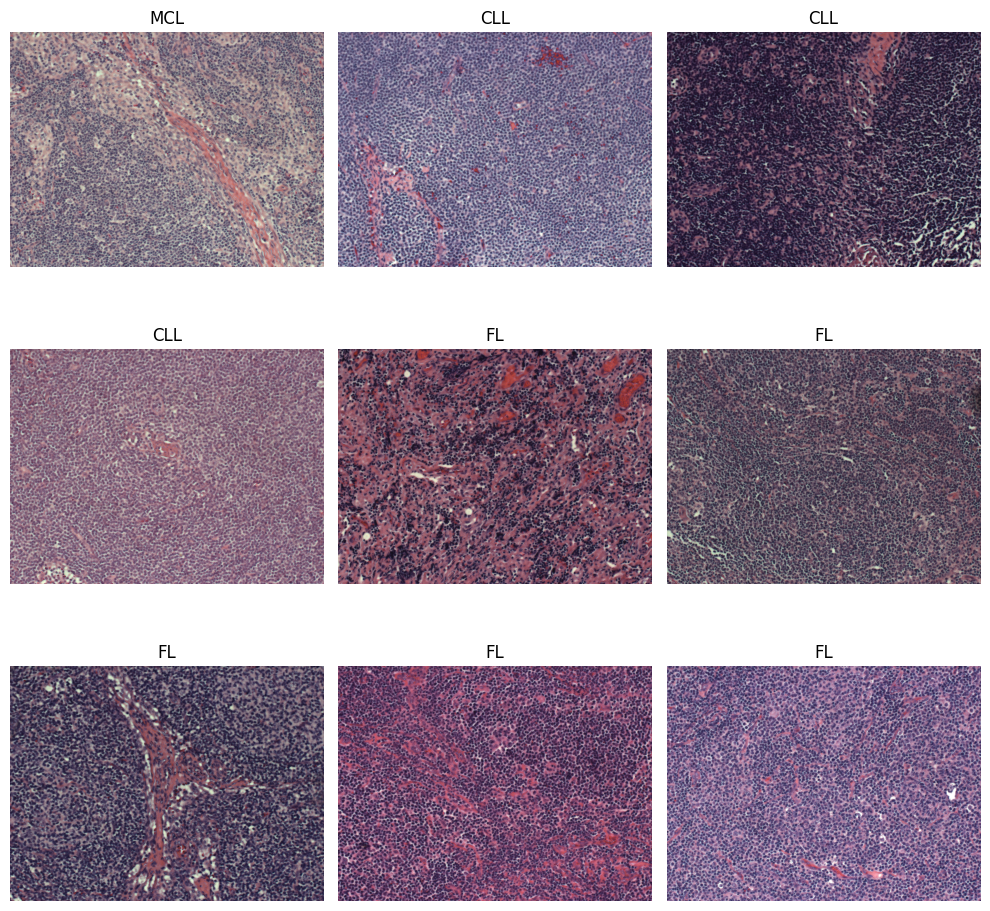

In [5]:
# Show 9 random images
fig, axes = plt.subplots(3,3, figsize=(10,10))
for ax in axes.flatten():
    idx = np.random.randint(0, len(raw_dataset))
    img, label = raw_dataset[idx]
    ax.imshow(img)
    ax.set_title(raw_dataset.classes[label])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
for i in range(5):
    idx = np.random.randint(0, len(raw_dataset))
    img, label = raw_dataset[idx]
    print(f"Image {idx} - original size: {img.size}") 

Image 332 - original size: (1388, 1040)
Image 262 - original size: (1388, 1040)
Image 126 - original size: (1388, 1040)
Image 338 - original size: (1388, 1040)
Image 9 - original size: (1388, 1040)


## Data Preparation

### Splitting

In [7]:
targets = np.array(raw_dataset.targets) 
indices = np.arange(len(raw_dataset))

train_idx, temp_idx, train_labels, temp_labels = train_test_split(indices, targets, test_size=0.3, random_state=42, stratify=targets)

val_idx, test_idx, val_labels, test_labels = train_test_split(temp_idx, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

# create subsets
train_dataset = Subset(raw_dataset, train_idx)
val_dataset   = Subset(raw_dataset, val_idx)
test_dataset  = Subset(raw_dataset, test_idx)

### Transformation & Data Loaders

In [8]:
img_size = 224

train_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    
    A.Rotate(limit=10, border_mode=0, p=0.5),  

    A.Affine(
        translate_percent={"x":0.1, "y":0.1},
        rotate=0,                    # mix?
        shear=10,
        scale=(0.9, 1.1),
        interpolation=1,             # nearst pixels?
        p=0.5
    ),
    
    A.HorizontalFlip(p=0.5),

    A.RandomBrightnessContrast(
        brightness_limit=(0.2, 1.2), contrast_limit=0, p=0.5
    ),
    
    
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),

    ToTensorV2()
])

In [9]:
val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),        
    transforms.ToTensor(),                          
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

In [10]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform   = val_test_transform
test_dataset.dataset.transform  = val_test_transform

In [11]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Models

## ResNet

In [12]:
class LymphModelResnet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.resnet_weights = models.ResNet50_Weights.DEFAULT
        self.resnet = models.resnet50(weights=self.resnet_weights)
        self.resnet_backbone = nn.Sequential(
            *list(self.resnet.children())[:-2]
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.resnet.fc.in_features, self.num_classes)

    def forward(self, x):
        features = self.resnet_backbone(x)
        features = self.avgpool(features)
        features = features.view(features.size(0), -1)
        logits = self.fc(features)
        return logits

In [13]:
num_classes = len(raw_dataset.classes)
model = LymphModelResnet(num_classes)

for param in model.resnet_backbone.parameters():
    param.requires_grad = False

# Unfreeze layer 4
for param in model.resnet_backbone[-1].parameters():
    param.requires_grad = True
    
optimizer = torch.optim.Adam(list(filter(lambda p: p.requires_grad, model.parameters())), lr=1e-4)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


In [14]:
def train_one_epoch():
    num_training_batches = 0
    training_loss = 0.0
    training_losses = []

    model.train()
    model.to(device)
    
    for images, labels in train_loader:

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        num_training_batches += 1
        loss_batch_train = loss.item()
        training_losses.append(loss_batch_train)

        training_loss += loss_batch_train
        # print(f"Epoch {epoch}, Batch {num_training_batches}: Loss = {loss.item()}")

    avg_loss_epoch_train = training_loss / num_training_batches
    print(f"Epoch {epoch} - Training Loss: {avg_loss_epoch_train:.4f}")

    return avg_loss_epoch_train

In [15]:
def validate_one_epoch():
    model.eval()
    model.to(device)
    
    num_val_batches = 0
    val_loss = 0.0
    val_losses = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
        
            logits = model(images)
            loss = criterion(logits, labels)
        
            num_val_batches += 1
            loss_batch_val = loss.item()
            val_losses.append(loss_batch_val)
    
            val_loss += loss_batch_val
            # print(f"Epoch {epoch}, Batch {num_val_batches}: Loss = {loss.item()}")
            
        avg_loss_epoch_validation = val_loss / num_val_batches
        print(f"Validation Loss: {avg_loss_epoch_validation:.4f}")
    
        return avg_loss_epoch_validation

In [16]:
epochs = 100
model.to(device)
training_losses = []
validation_losses = []
epochs_no_change = 0
best_val = float('inf')

for epoch in range(epochs):
    print(next(model.parameters()).device)

    train_loss = train_one_epoch()
    validation_loss = validate_one_epoch()

    training_losses.append(train_loss)
    validation_losses.append(validation_loss)

    if validation_loss <= best_val:
        best_val = validation_loss
        epochs_no_change = 0
        torch.save(model.state_dict(), "/kaggle/working/best_model_rn_imagenet.pt")
    else:
        epochs_no_change += 1
        if (epochs_no_change >= 3):
            print(f"early stopping at epoch {epoch+1}")
            print(f"Best validation: {best_val}")
            model.load_state_dict(torch.load("/kaggle/working/best_model_rn_imagenet.pt"))

            model.to(device)
            break

cuda:0
Epoch 0 - Training Loss: 1.0779
Validation Loss: 1.0718
cuda:0
Epoch 1 - Training Loss: 0.9301
Validation Loss: 1.0203
cuda:0
Epoch 2 - Training Loss: 0.7943
Validation Loss: 0.9320
cuda:0
Epoch 3 - Training Loss: 0.6835
Validation Loss: 0.8269
cuda:0
Epoch 4 - Training Loss: 0.5410
Validation Loss: 0.7528
cuda:0
Epoch 5 - Training Loss: 0.3724
Validation Loss: 0.6660
cuda:0
Epoch 6 - Training Loss: 0.3288
Validation Loss: 0.5866
cuda:0
Epoch 7 - Training Loss: 0.2421
Validation Loss: 0.5665
cuda:0
Epoch 8 - Training Loss: 0.1479
Validation Loss: 0.5308
cuda:0
Epoch 9 - Training Loss: 0.1446
Validation Loss: 0.5247
cuda:0
Epoch 10 - Training Loss: 0.0861
Validation Loss: 0.4819
cuda:0
Epoch 11 - Training Loss: 0.0598
Validation Loss: 0.4835
cuda:0
Epoch 12 - Training Loss: 0.0853
Validation Loss: 0.4974
cuda:0
Epoch 13 - Training Loss: 0.1335
Validation Loss: 0.4674
cuda:0
Epoch 14 - Training Loss: 0.0607
Validation Loss: 0.5313
cuda:0
Epoch 15 - Training Loss: 0.0384
Validation

In [17]:
def inference(image):
    image.to(device)
    model.to(device)

    model.eval()
    image = transform(image)
    if image.dim == 3:
        image = image.unsqueeze(0)

    with torch.no_grad():
        logits = model(image)
        probabilities = logits.softmax(dim=1)
        print(probabilities)
        print(torch.argmax(probabilities, dim=1))

In [18]:
all_preds = []
all_labels = []

model.load_state_dict(torch.load("/kaggle/working/best_model_rn_imagenet.pt"))
model.to(device)

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # get predicted class
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8036
Precision: 0.8232
Recall: 0.8036
F1-score: 0.8086


## DenseNet (ImageNet)

In [19]:
def train_full_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=50, patience=5, model_path="model.pt"):
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        
        print(f"Epoch {epoch+1}/{epochs} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")
        print(f"Metrics -> Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            print("Model Saved")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early Stopping triggered at epoch {epoch+1}")
                break
    
    model.load_state_dict(torch.load(model_path))
    return model

In [20]:
class DenseNetImageNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.model = models.densenet121(weights='IMAGENET1K_V1')
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)
    def forward(self, x): return self.model(x)

model_img = DenseNetImageNet().to(device)
for param in model_img.model.features.parameters(): param.requires_grad = False
for param in model_img.model.features.denseblock4.parameters(): param.requires_grad = True 

optimizer_img = torch.optim.Adam(filter(lambda p: p.requires_grad, model_img.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()

print("\n Training ImageNet Model")
model_img = train_full_model(model_img, train_loader, val_loader, optimizer_img, criterion, device, 
                             epochs=50, patience=5, model_path="/kaggle/working/best_dn_imagenet.pt")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 159MB/s]


 Training ImageNet Model


Epoch 1/50 | Train: 1.0157 | Val: 1.0146
Metrics -> Acc: 0.4643 | Prec: 0.4821 | Rec: 0.4643
Model Saved
Epoch 2/50 | Train: 0.7110 | Val: 0.8952
Metrics -> Acc: 0.5714 | Prec: 0.5778 | Rec: 0.5714
Model Saved
Epoch 3/50 | Train: 0.5123 | Val: 0.7638
Metrics -> Acc: 0.7143 | Prec: 0.7173 | Rec: 0.7143
Model Saved
Epoch 4/50 | Train: 0.4166 | Val: 0.6823
Metrics -> Acc: 0.7321 | Prec: 0.7362 | Rec: 0.7321
Model Saved
Epoch 5/50 | Train: 0.3230 | Val: 0.6007
Metrics -> Acc: 0.7321 | Prec: 0.7362 | Rec: 0.7321
Model Saved
Epoch 6/50 | Train: 0.2562 | Val: 0.5579
Metrics -> Acc: 0.7500 | Prec: 0.7497 | Rec: 0.7500
Model Saved
Epoch 7/50 | Train: 0.2039 | Val: 0.5249
Metrics -> Acc: 0.7679 | Prec: 0.7693 | Rec: 0.7679
Model Saved
Epoch 8/50 | Train: 0.1635 | Val: 0.4991
Metrics -> Acc: 0.7857 | Prec: 0.7859 | Rec: 0.7857
Model Saved
Epoch 9/50 | Train: 0.1883 | Val: 0.4793
Metrics -> Acc: 0.7857 | Prec: 0.7854 | Rec: 0.7857
Model Saved
Epoch 10/50 | Train: 0.1774 | Val: 0.4634
Metrics -> Ac

## DenseNet (Medical)

In [21]:
class DenseNetMedical(nn.Module):
    def __init__(self, num_classes=3, weights_path=None):
        super().__init__()
        self.model = models.densenet121(weights=None)
        if weights_path:
            ckpt = torch.load(weights_path, map_location='cpu')
            state_dict = ckpt['state_dict'] if 'state_dict' in ckpt else ckpt
            state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
            self.model.load_state_dict(state_dict, strict=False)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)
    def forward(self, x): return self.model(x)

weights_path = "/kaggle/input/kimianet/KimiaNetPyTorchWeights.pth"
model_med = DenseNetMedical(weights_path=weights_path).to(device)

for param in model_med.model.features.parameters(): param.requires_grad = False
for param in model_med.model.features.denseblock4.parameters(): param.requires_grad = True

optimizer_med = torch.optim.Adam(filter(lambda p: p.requires_grad, model_med.parameters()), lr=1e-4)

print("\n Training Medical Model")
model_med = train_full_model(model_med, train_loader, val_loader, optimizer_med, criterion, device, 
                             epochs=50, patience=5, model_path="/kaggle/working/best_dn_medical.pt")


 Training Medical Model
Epoch 1/50 | Train: 1.0830 | Val: 1.0872
Metrics -> Acc: 0.5893 | Prec: 0.5791 | Rec: 0.5893
Model Saved
Epoch 2/50 | Train: 0.9592 | Val: 1.0249
Metrics -> Acc: 0.5714 | Prec: 0.6299 | Rec: 0.5714
Model Saved
Epoch 3/50 | Train: 0.8660 | Val: 0.9381
Metrics -> Acc: 0.5893 | Prec: 0.6477 | Rec: 0.5893
Model Saved
Epoch 4/50 | Train: 0.7856 | Val: 0.8558
Metrics -> Acc: 0.6607 | Prec: 0.6730 | Rec: 0.6607
Model Saved
Epoch 5/50 | Train: 0.7577 | Val: 0.8027
Metrics -> Acc: 0.6964 | Prec: 0.7103 | Rec: 0.6964
Model Saved
Epoch 6/50 | Train: 0.7070 | Val: 0.7517
Metrics -> Acc: 0.6964 | Prec: 0.7007 | Rec: 0.6964
Model Saved
Epoch 7/50 | Train: 0.6984 | Val: 0.7289
Metrics -> Acc: 0.7143 | Prec: 0.7373 | Rec: 0.7143
Model Saved
Epoch 8/50 | Train: 0.6529 | Val: 0.7070
Metrics -> Acc: 0.6964 | Prec: 0.6763 | Rec: 0.6964
Model Saved
Epoch 9/50 | Train: 0.6142 | Val: 0.6774
Metrics -> Acc: 0.7321 | Prec: 0.7366 | Rec: 0.7321
Model Saved
Epoch 10/50 | Train: 0.5497 | 

In [22]:
def final_test(model, loader, name):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            out = model(imgs)
            preds = torch.argmax(out, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    print(f"Final Results for {name}:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")

final_test(model_img, test_loader, "DenseNet ImageNet")
final_test(model_med, test_loader, "DenseNet Medical")

Final Results for DenseNet ImageNet:
Accuracy:  0.8246
Precision: 0.8258
Recall:    0.8246
F1-Score:  0.8215
Final Results for DenseNet Medical:
Accuracy:  0.8421
Precision: 0.8493
Recall:    0.8421
F1-Score:  0.8419


# Explainable AI

## GradCAM++ Implementation

In [23]:
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_registered = False

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        if not self.hook_registered:
            self.target_layer.register_forward_hook(forward_hook)
            if hasattr(self.target_layer, 'register_full_backward_hook'):
                self.target_layer.register_full_backward_hook(backward_hook)
            else:
                self.target_layer.register_backward_hook(backward_hook)
            self.hook_registered = True

    
    def generate_cam(self, input_image, class_idx=None):
        self.model.eval()
        self.register_hooks()

        output = self.model(input_image)

        if class_idx is None:
            class_idx = torch.argmax(output).item()

        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1

        self.model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)

        # gradients & activations
        grads = self.gradients
        acts = self.activations
        
        # calculate alphas
        grads_pow2 = grads.pow(2)
        grads_pow3 = grads.pow(3)
        
        sum_acts = acts.sum(dim=(2, 3), keepdim=True)
        eps = 1e-8
        
        alpha_denom = grads_pow2.mul(2) + sum_acts.mul(grads_pow3)
        alpha_denom = torch.where(alpha_denom != 0, alpha_denom, torch.ones_like(alpha_denom))
        alphas = grads_pow2 / alpha_denom

        weights = (alphas * torch.relu(grads)).sum(dim=(2, 3), keepdim=True)
        
        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = (cam - cam.min()) / (cam.max() + eps)
        
        return cam.detach().cpu().squeeze().numpy()

    
    def visualize_cam(self, cam, original_tensor):
        # denormalization & upsampleing
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        img_np = original_tensor.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np * std) + mean         # Un-normalize
        img_np = np.clip(img_np, 0, 1)

        cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))

        # create heatmap
        heatmap = plt.cm.jet(cam_resized)[:, :, :3]
        overlay = (heatmap * 0.4 + img_np * 0.6)
        overlay = (overlay / overlay.max()) 

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(img_np)
        ax[0].set_title("Original Image")
        ax[0].axis("off")
        
        ax[1].imshow(cam_resized, cmap="jet")
        ax[1].set_title("GradCAM++ Heatmap")
        ax[1].axis("off")
        
        ax[2].imshow(overlay)
        ax[2].set_title("Heatmap Overlay")
        ax[2].axis("off")
        plt.show()

## Using GradCAM++

In [24]:
test_image, test_label = test_dataset[np.random.randint(len(test_dataset))]
input_tensor = test_image.unsqueeze(0).to(device)

ResNet50 GradCAM++ Visualization


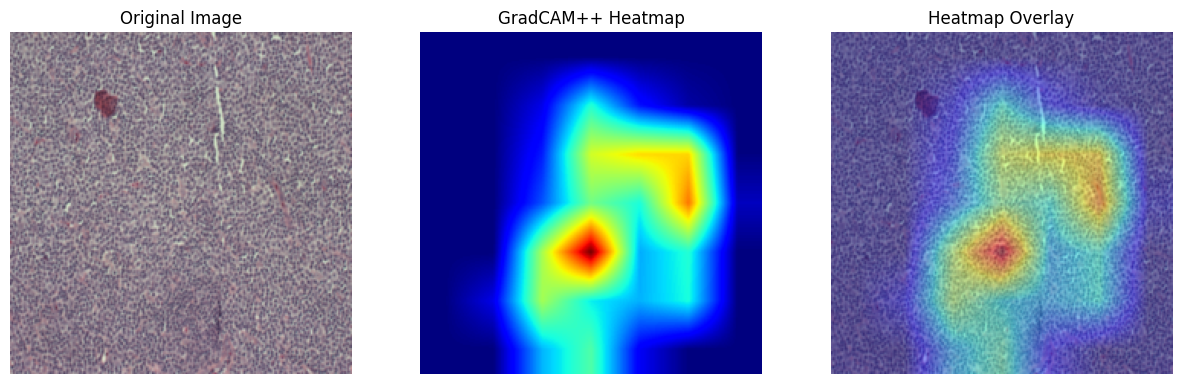

In [25]:
print("=" * 50)
print("ResNet50 GradCAM++ Visualization")
print("=" * 50)


model_resnet = LymphModelResnet(num_classes)
model_resnet.load_state_dict(torch.load("/kaggle/working/best_model_rn_imagenet.pt"))
model_resnet.to(device)
model_resnet.eval()

target_layer_resnet = model_resnet.resnet_backbone[-1][-1].conv3

gradcam_resnet = GradCAMPlusPlus(model_resnet, target_layer_resnet)
cam_resnet = gradcam_resnet.generate_cam(input_tensor)
gradcam_resnet.visualize_cam(cam_resnet, test_image)

DenseNet ImageNet GradCAM++ Visualization


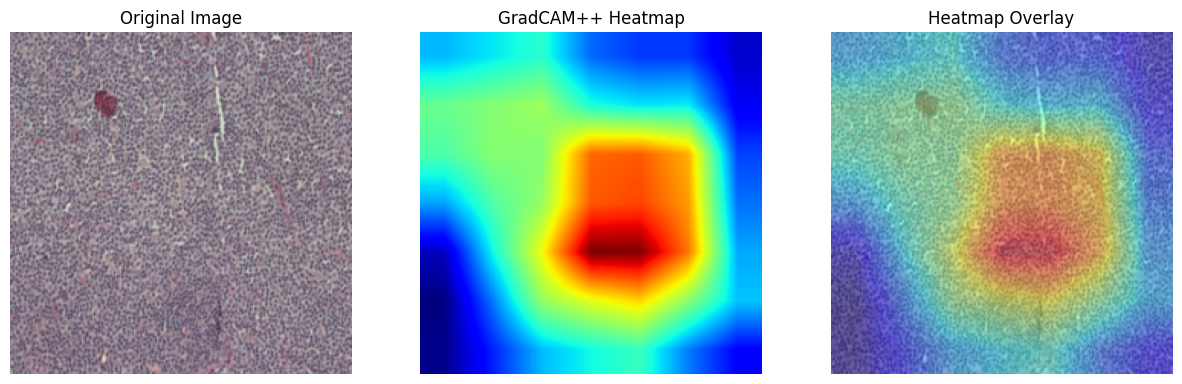

In [26]:
print("=" * 50)
print("DenseNet ImageNet GradCAM++ Visualization")
print("=" * 50)

model_densenet_img = DenseNetImageNet().to(device)
model_densenet_img.load_state_dict(torch.load("/kaggle/working/best_dn_imagenet.pt"))
model_densenet_img.eval()

target_layer_densenet_img = model_densenet_img.model.features.denseblock4.denselayer16.conv2

gradcam_densenet_img = GradCAMPlusPlus(model_densenet_img, target_layer_densenet_img)
cam_densenet_img = gradcam_densenet_img.generate_cam(input_tensor)
gradcam_densenet_img.visualize_cam(cam_densenet_img, test_image)

DenseNet Medical GradCAM++ Visualization


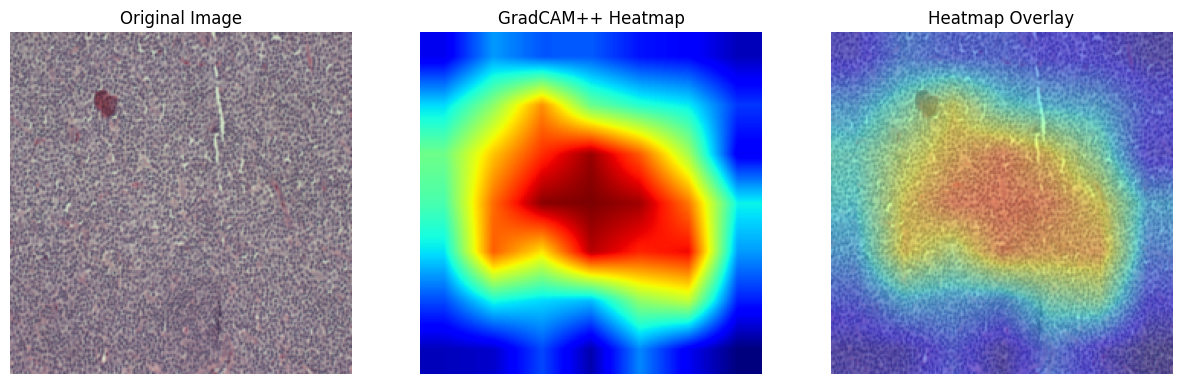

In [27]:
print("=" * 50)
print("DenseNet Medical GradCAM++ Visualization")
print("=" * 50)

model_densenet_med = DenseNetMedical(weights_path=weights_path).to(device)
model_densenet_med.load_state_dict(torch.load("/kaggle/working/best_dn_medical.pt"))
model_densenet_med.eval()

target_layer_densenet_med = model_densenet_med.model.features.denseblock4.denselayer16.conv2

gradcam_densenet_med = GradCAMPlusPlus(model_densenet_med, target_layer_densenet_med)
cam_densenet_med = gradcam_densenet_med.generate_cam(input_tensor)
gradcam_densenet_med.visualize_cam(cam_densenet_med, test_image)

In [28]:
def print_prediction(model, image_tensor, actual_label, classes, model_name="Model"):
    model.eval()
    input_batch = image_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        logits = model(input_batch)
        probabilities = torch.softmax(logits, dim=1)
        pred_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][pred_idx].item()

    pred_class = classes[pred_idx]
    actual_class = classes[actual_label]

    print(f"\n--- {model_name} Prediction ---")
    print(f"Predicted Class: {pred_class} ({confidence*100:.2f}% confidence)")
    print(f"Actual Class:    {actual_class}")
    print(f"Result:          {'CORRECT' if pred_idx == actual_label else 'WRONG'}")

print_prediction(model_resnet, test_image, test_label, raw_dataset.classes, "ResNet50")
print_prediction(model_densenet_img, test_image, test_label, raw_dataset.classes, "DenseNet ImageNet")
print_prediction(model_densenet_med, test_image, test_label, raw_dataset.classes, "DenseNet Medical")


--- ResNet50 Prediction ---
Predicted Class: CLL (83.17% confidence)
Actual Class:    CLL
Result:          CORRECT

--- DenseNet ImageNet Prediction ---
Predicted Class: CLL (60.49% confidence)
Actual Class:    CLL
Result:          CORRECT

--- DenseNet Medical Prediction ---
Predicted Class: CLL (82.32% confidence)
Actual Class:    CLL
Result:          CORRECT
